# Data Challenge 2 - Reorder Sentences

Submitted by: Siqi Liu

Student ID: 20428295

WatIAm: sq2liu

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sentence-ordering')

In [3]:
!pip install transformers==4.2.2

     |████████████████████████████████| 1.8MB 18.0MB/s 
     |████████████████████████████████| 2.9MB 53.5MB/s 
     |████████████████████████████████| 890kB 51.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c8dcc477da7c50d6f9c2559e322d50c38dcaf5bfec7332670e73628e67fc945b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import torch
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler, SequentialSampler

In [5]:
from src import config
from src import data
from src import graph
from src import model
from src import utils

In [6]:
from importlib import reload

def reload_all():
  reload(config)
  reload(data)
  reload(graph)
  reload(model)
  reload(utils)

### Set-up

In [7]:
device = utils.get_device()

Current device: cuda


### Load and Split Data

In [8]:
labeled_set = data.load_dataset(config.args['dir'] + config.args['labeled_filename'])
pred_set = data.load_dataset(config.args['dir'] + config.args['pred_filename'])

/content/drive/MyDrive/Colab Notebooks/sentence-ordering/data/train.pkl loaded. Size: 590226
/content/drive/MyDrive/Colab Notebooks/sentence-ordering/data/test.pkl loaded. Size: 2000


In [9]:
train_set, val_set = data.get_train_val_set(
    labeled_set,
    config.args['num_val_docs'],
    config.args['num_train_docs']
)

train_set size: 100000
val_set size: 500


### Load Models and Tokenizer

In [10]:
# model_fsent = model.load_model()

model_fsent = torch.load('{:s}fsent_model_checkpoint.pt'.format(
    config.args['dir'] + config.args['model_output_dir']
))

model_fsent.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
model_pair = model.load_model()

# model_pair = torch.load('{:s}pair_model_checkpoint.pt'.format(
#     config.args['dir'] + config.args['model_output_dir']
# ))

model_pair.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
tokenizer = model.load_tokenizer()

### First Sentence Datasets, Sampler and DataLoaders

In [ ]:
train_dataset_fsent = data.FirstSentenceDataset(train_set, tokenizer, config.args['model_fsent']['max_length'])
val_dataset_fsent = data.FirstSentenceDataset(val_set, tokenizer, config.args['model_fsent']['max_length'])

Dataset loaded. Size: 600000
Dataset loaded. Size: 3000


In [ ]:
train_weights_fsent, weight_one_fsent = data.get_weights_for_balanced_classes(
    train_dataset_fsent,
    target_ratio=config.args['model_fsent']['target_ratio']
)

train_sampler_fsent = WeightedRandomSampler(
    weights=train_weights_fsent,
    num_samples=config.args['model_fsent']['num_train_samples'],
    replacement=False
)

val_sampler_fsent = SequentialSampler(
    data_source=val_dataset_fsent
)

Weight for Ones: 5.0000


In [ ]:
dataset_sizes_fsent = {
    'train' : config.args['model_fsent']['num_train_samples'],
    'val' : len(val_dataset_fsent),
}

print('train Dataset size: {:d}\nval Dataset size: {:d}'.format(
    dataset_sizes_fsent['train'], dataset_sizes_fsent['val']
))

train Dataset size: 10000
val Dataset size: 3000


In [ ]:
train_dataloader_fsent = DataLoader(
    train_dataset_fsent,
    sampler=train_sampler_fsent,
    batch_size=config.args['model_fsent']['batch_size']
)

val_dataloader_fsent = DataLoader(
    val_dataset_fsent,
    sampler=val_sampler_fsent,
    batch_size=config.args['model_fsent']['batch_size']
)

In [ ]:
dataloaders_fsent = {
    'train' : train_dataloader_fsent,
    'val' : val_dataloader_fsent
}

print('train DataLoader size: {:d}\nval DataLoader size: {:d}'.format(
    len(dataloaders_fsent['train']), len(dataloaders_fsent['val'])
))

train DataLoader size: 313
val DataLoader size: 94


### First Sentence Optimizer and Scheduler

In [ ]:
optimizer_fsent = model.get_optimizer(
    model_fsent,
    config.args['model_fsent']['lr'],
    config.args['model_fsent']['adam_eps']
)

In [ ]:
scheduler_fsent = model.get_scheduler(
    optimizer_fsent,
     config.args['model_fsent']['warmup_steps'],
    len(train_dataloader_fsent) * config.args['model_fsent']['num_epochs']
)

In [ ]:
model_fsent, best_epoch_fsent, losses_fsent, accuracies_fsent = model.train_fsent(
    model=model_fsent,
    device=device,
    dataloaders=dataloaders_fsent,
    dataset_sizes=dataset_sizes_fsent,
    optimizer=optimizer_fsent,
    scheduler=scheduler_fsent,
    num_epochs=config.args['model_fsent']['num_epochs']
)

Epoch 1/3
----------



train Loss: 0.1354; Acc: 0.9578



val Loss: 0.1029; Acc: 0.9623
Best model so far! Saved checkpoint.

Epoch 2/3
----------



train Loss: 0.0841; Acc: 0.9743



val Loss: 0.0593; Acc: 0.9793
Best model so far! Saved checkpoint.

Epoch 3/3
----------



train Loss: 0.0735; Acc: 0.9758



val Loss: 0.0625; Acc: 0.9807
Best model so far! Saved checkpoint.

Training complete in 13m 57s
Best Val Acc: 0.980667 at Epoch: 2


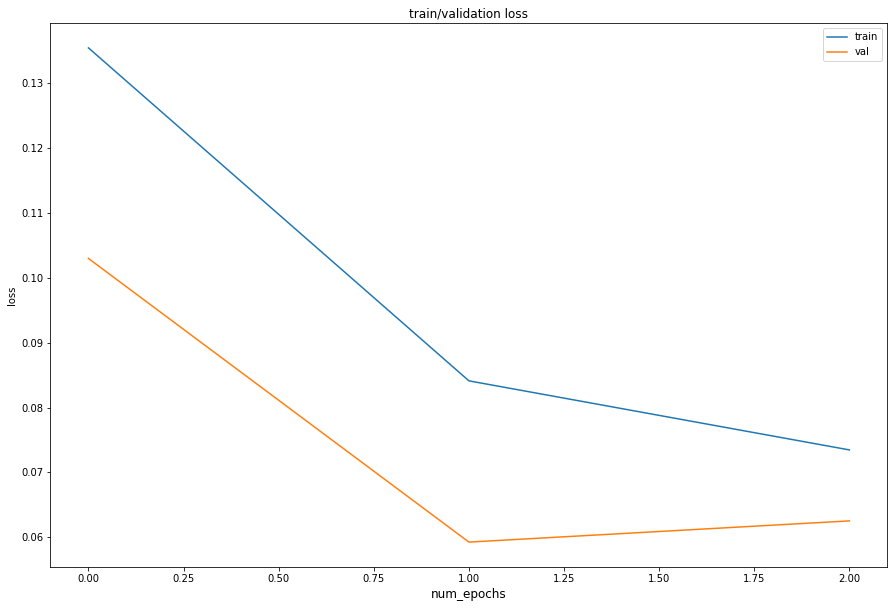

In [ ]:
utils.plot_statistics("loss", losses_fsent)

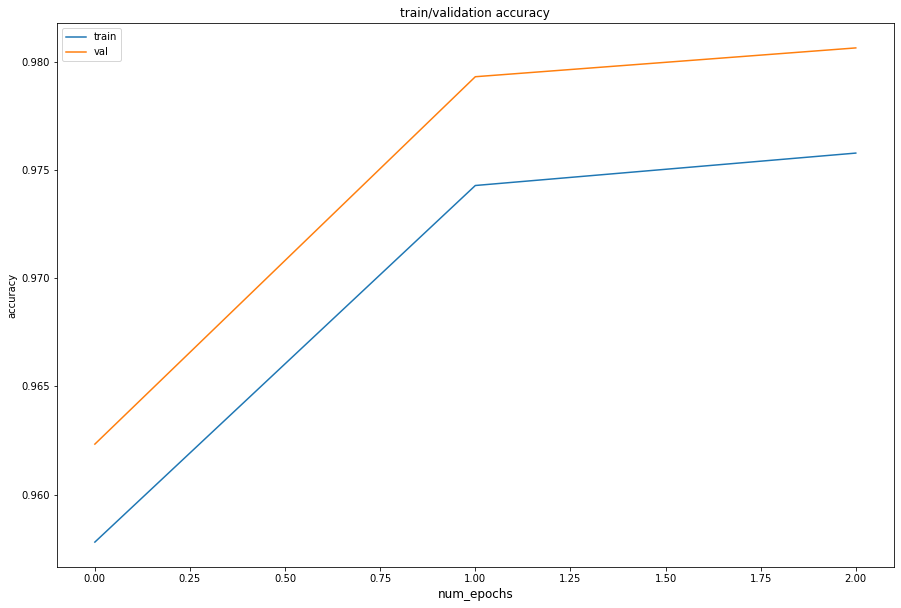

In [ ]:
utils.plot_statistics("accuracy", accuracies_fsent)

### Pair Datasets, Sampler and DataLoaders

In [13]:
train_dataset_pair = data.SentencePairDataset(train_set, tokenizer, config.args['model_pair']['max_length'])
# val_dataset_pair = data.SentencePairDataset(val_set, tokenizer, config.args['model_pair']['max_length'])

Dataset loaded. Size: 3000000


In [14]:
train_weights_pair, weight_one_pair = data.get_weights_for_balanced_classes(
    train_dataset_pair,
    target_ratio=config.args['model_pair']['target_ratio']
)

train_sampler_pair = WeightedRandomSampler(
    weights=train_weights_pair,
    num_samples=config.args['model_pair']['num_train_samples'],
    replacement=False
)

# train_sampler_pair = RandomSampler(
#     data_source=train_dataset_pair,
#     num_samples=config.args['model_pair']['num_train_samples'],
#     replacement=True
# )

# val_sampler_pair = SequentialSampler(
#     data_source=val_dataset_pair
# )

Weight for Ones: 5.0000


In [15]:
# dataset_sizes_pair = {
#     'train' : config.args['model_pair']['num_train_samples'],
#     'val' : len(val_dataset_pair),
# }

dataset_sizes_pair = {
    'train' : config.args['model_pair']['num_train_samples']
}

# print('train Dataset size: {:d}\nval Dataset size: {:d}'.format(
#     dataset_sizes_pair['train'], dataset_sizes_pair['val']
# ))

In [16]:
train_dataloader_pair = DataLoader(
    train_dataset_pair,
    sampler=train_sampler_pair,
    batch_size=config.args['model_pair']['batch_size']
)

# val_dataloader_pair = DataLoader(
#     val_dataset_pair,
#     sampler=val_sampler_pair,
#     batch_size=config.args['model_pair']['batch_size']
# )

In [17]:
# dataloaders_pair = {
#     'train' : train_dataloader_pair,
#     'val' : val_dataloader_pair
# }

dataloaders_pair = {
    'train' : train_dataloader_pair
}

# print('train DataLoader size: {:d}\nval DataLoader size: {:d}'.format(
#     len(dataloaders_pair['train']), len(dataloaders_pair['val'])
# ))

### Pair Optimizer and Scheduler

In [ ]:
optimizer_pair = model.get_optimizer(
    model_pair,
    config.args['model_pair']['lr'],
    config.args['model_pair']['adam_eps']
)

In [ ]:
scheduler_pair = model.get_scheduler(
    optimizer_pair,
    config.args['model_pair']['warmup_steps'],
    len(train_dataloader_pair) * config.args['model_pair']['num_epochs']
)

In [ ]:
model_pair, best_epoch_pair, losses_pair, accuracies_pair, corrs_pair = model.train_pair(
    model=model_pair,
    model_fsent=model_fsent,
    tokenizer=tokenizer,
    device=device,
    val_set=val_set,
    dataloaders=dataloaders_pair,
    dataset_sizes=dataset_sizes_pair,
    optimizer=optimizer_pair,
    scheduler=scheduler_pair,
    num_epochs=config.args['model_pair']['num_epochs']
)

Epoch 1/20
----------


RuntimeError: ignored

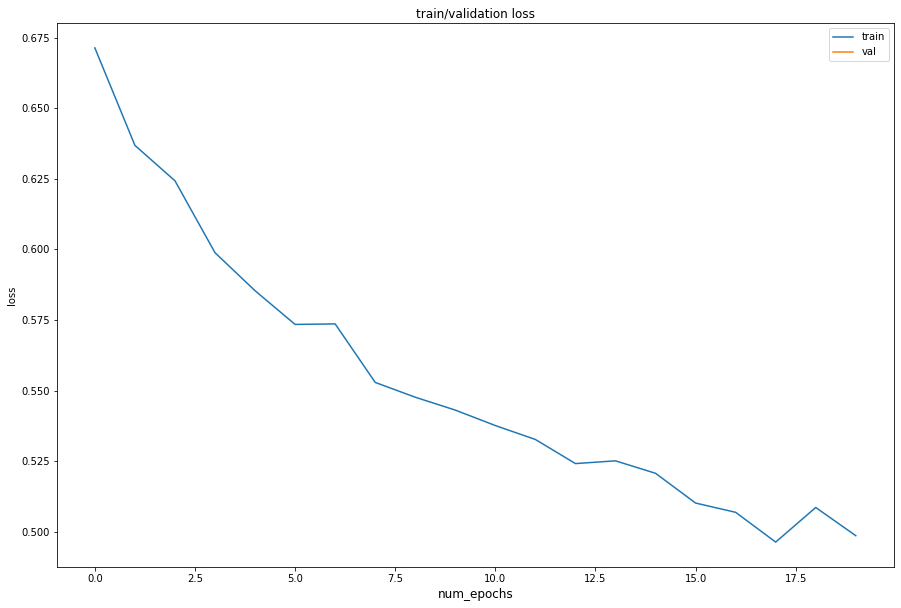

In [ ]:
utils.plot_statistics("loss", losses_pair)

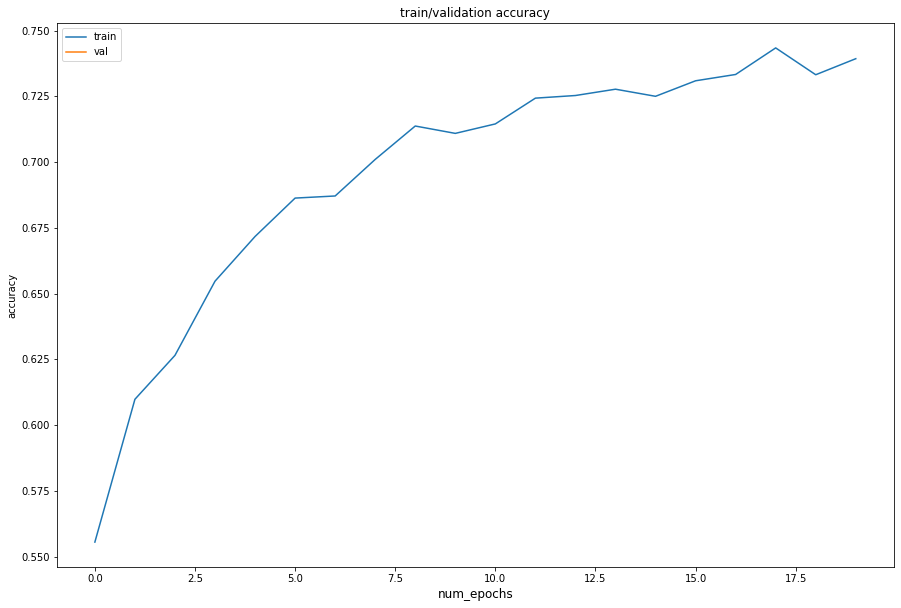

In [ ]:
utils.plot_statistics("accuracy", accuracies_pair)

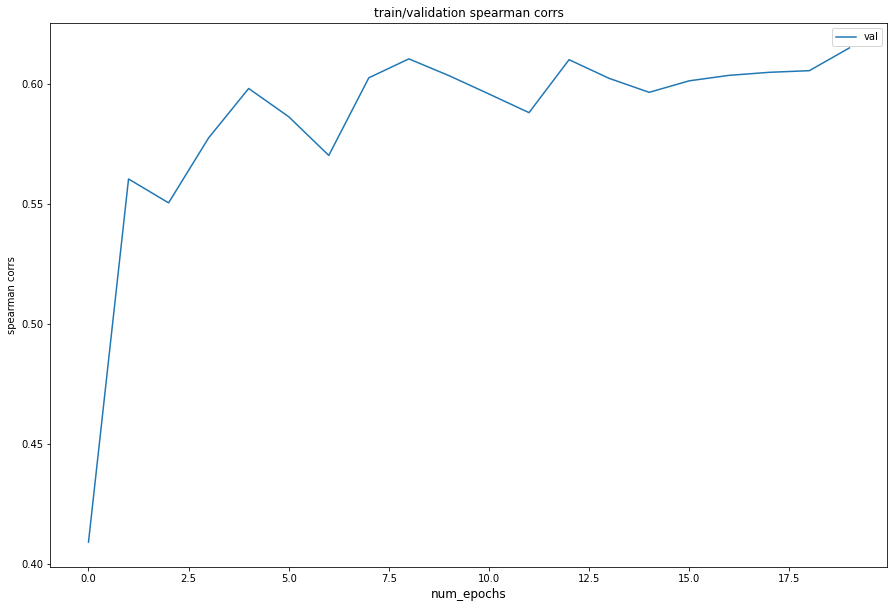

In [ ]:
utils.plot_statistics("spearman corrs", corrs_pair)

### Example

In [ ]:
doc = val_set[153]

doc

In [ ]:
model.predict(doc, device, model_fsent, model_pair, tokenizer)

In [ ]:
# predict first sentence position
fsent_pos = model.predict_fsent_pos(doc, device, model_fsent, tokenizer)

fsent_pos

In [ ]:
# predict sentence pairs logits
pair_logits = model.predict_pair_logits(doc, device, model_pair, tokenizer)

pair_logits

In [ ]:
# construct graph based on predictions
num_vertices = len(doc['sentences'])
g = model.make_graph(num_vertices, pair_logits)

g.graph

In [ ]:
# sort and get the order
if config.args['graph_method'] == 'max_flow':
    order, weight = g.max_flow(fsent_pos)
elif config.args['graph_method'] == 'greedy':
    order, weight = g.greedy(fsent_pos)
else:
    raise InvalidInputError()

order, weight

In [ ]:
indexes = [-1] * num_vertices
for p, o in enumerate(order):
    indexes[o] = p

indexes

### Validation Set Score

In [ ]:
mean_val_corr, worst_corr_docs = model.evaluate(val_set, device, model_fsent, model_pair, tokenizer)

mean_val_corr

0.6150857142857131

In [ ]:
worst_corr_docs

[{'ID': 390043,
  'indexes': [5, 3, 1, 4, 2, 0],
  'sentences': ['The first decade of freedom brought mainly state reforms in the financing of cultural institutions and patronage; forcing self-sustainability in an often uncharted territory.',
   'However, unlike any other temporal marker in the development of Polish culture from the past, the year 1989 did not introduce any specific literary events or artistic manifestations.',
   'After 1989, the heavy government controls ended, and the radical economic changes were introduced.',
   'For a generation of accomplished writers the objectives and their moral quests remained the same as in the preceding period.',
   'The influx of new aesthetic and social ideas was accompanied by the Western market forces.',
   'With the fall of communism Polish culture and society began a process of profound transformation, marked by the return of democracy and redevelopment of civil society.']}]

In [ ]:
for i, d in enumerate(val_set):
    if d['ID'] == 390043:
        print(i)

53


### Submit

In [ ]:
submission = model.predict_submission(pred_set, device, model_fsent, model_pair, tokenizer)

submission

,ID,index1,index2,index3,index4,index5,index6
0,1,1,5,4,2,3,0
1,2,3,5,2,0,1,4
2,3,2,5,1,0,4,3
3,4,3,0,2,1,5,4
4,5,5,2,3,0,1,4
...,...,...,...,...,...,...,...
1995,1996,0,1,2,3,4,5
1996,1997,1,5,2,3,0,4
1997,1998,2,5,0,3,4,1
1998,1999,3,1,2,4,5,0


In [ ]:
submission.to_csv(config.args['dir'] + 'submission.csv', index=False)